# Klasifikace EMG signálů 

## Vypracoval Marek Tremel roku 2024, F23211

### Požadavky

- **Vstupní data**: přiložený soubor EMG.txt 
- **Grafické výstupy**: Graf závislosti iEMG na měření. Graf pro vybrané signály s vyznačenými oblasti, kde 
docházelo k nárůstu a poklesu aktivity EMG. 

- použité knihovny

In [7]:
import matplotlib.pyplot as plt
import numpy as np


Postup načtení proměnných z datové sady.

In [8]:
# Načtení dat ze souboru EMG.txt
data = np.loadtxt('../assets/EMG.txt')

# Extrahujeme časové razítko a hodnoty EMG signálu
time = data[:, 0] # časové razítko
emg1 = data[:, 1] # EMG signál 1
emg2 = data[:, 2] # EMG signál 2


Kód slouží pro zobrazení hrubého nezpracovaného grafu z načtené datové sady. EMG signály jsou zobrazeny proti času, což umožňuje vizualizaci jejich průběhu v čase.

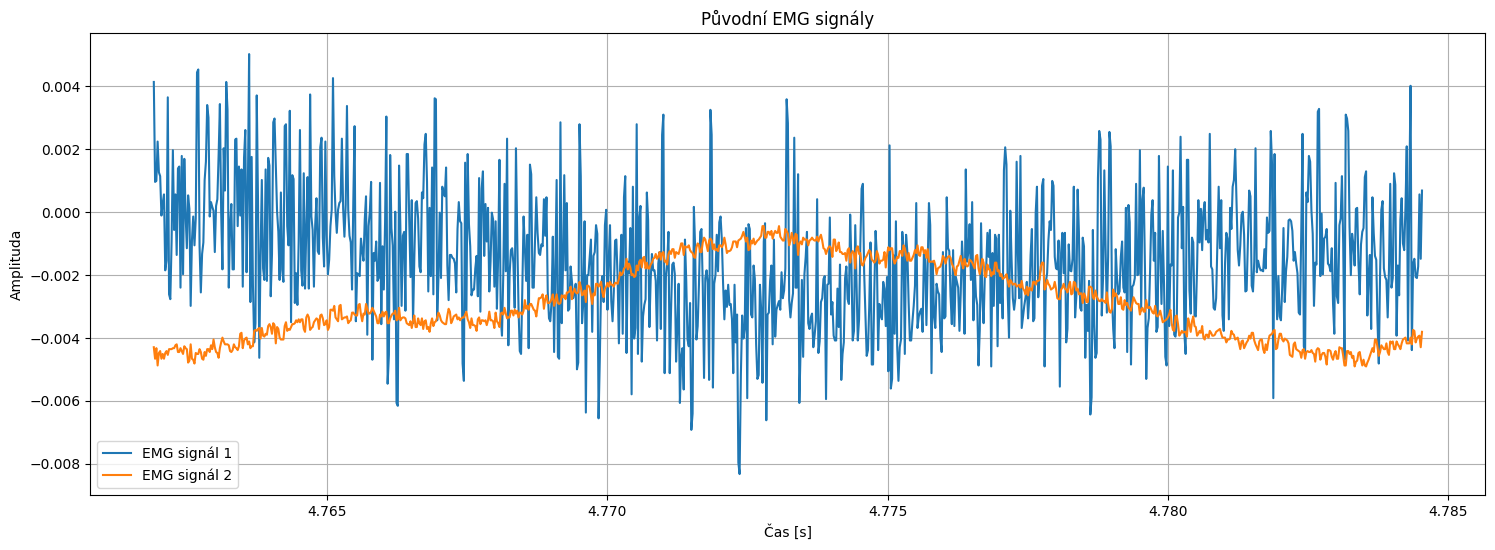

In [9]:
# Vykreslení původního EMG signálu
plt.figure(figsize=(18, 6))
plt.plot(time, emg1, label='EMG signál 1')
plt.plot(time, emg2, label='EMG signál 2')
plt.title('Původní EMG signály')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.legend()
plt.grid(True)
plt.show()


Tento kód nejprve spočítá absolutní hodnoty dvou EMG signálů a poté je vykreslí proti času.
Absolutní hodnotu používám pro eliminaci polarity. 
EMG signály mají kladné i záporné hodnoty. Absolutní hodnota zajistí, že se všechny hodnoty stanou kladnými.

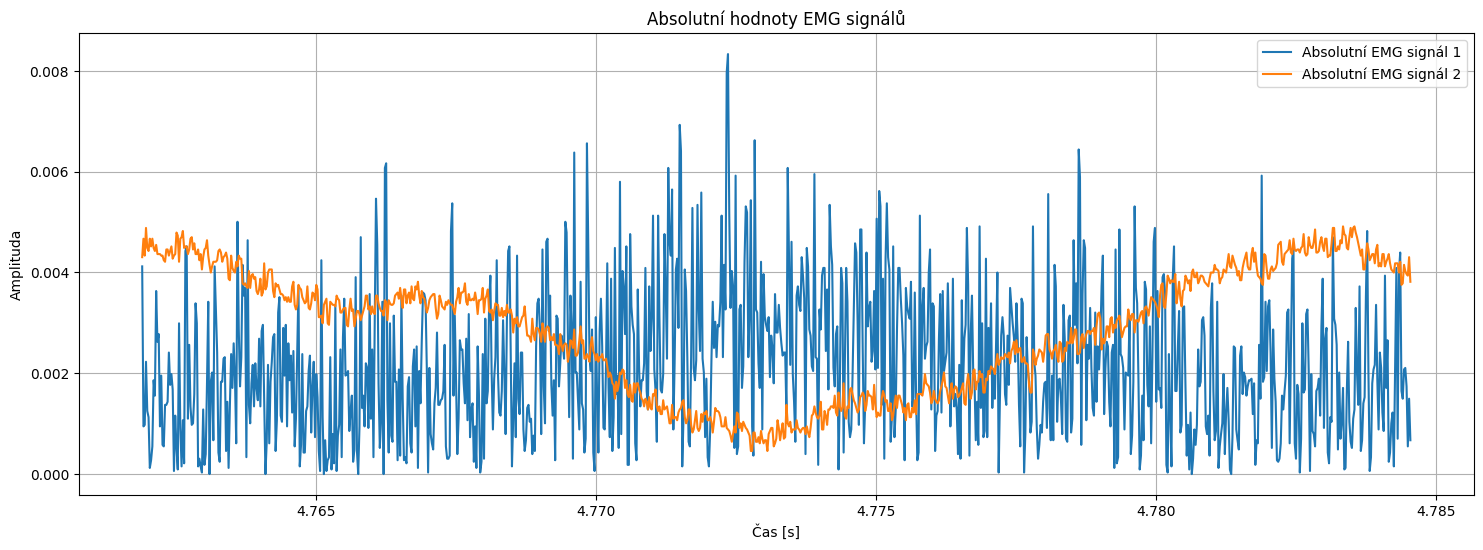

In [10]:
# Spočítání absolutní hodnoty EMG signálu
emg1_abs = np.abs(emg1)
emg2_abs = np.abs(emg2)


# Vykreslení absolutních hodnot EMG signálů
plt.figure(figsize=(18, 6))
plt.plot(time, emg1_abs, label='Absolutní EMG signál 1')
plt.plot(time, emg2_abs, label='Absolutní EMG signál 2')
plt.title('Absolutní hodnoty EMG signálů')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.legend()
plt.grid(True)
plt.show()


Tento kód slouží k výpočtu integrovaného EMG (iEMG) pomocí lichoběžníkové metody, následně počítá window iEMG a detekuje nárůsty a poklesy v těchto signálech. Výsledek je pak vyzobrazen pomocí grafu


### Lichoběžníková metoda(trapz)
Jejím principem je aproximace plochy pod grafem funkce **\( f(x) \)** lichoběžníkem a použitím jeho plochy jako přibližné hodnoty určitého integrálu funkce **\( f(x) \)** na intervalu **<a,b>**.[1]

Pokud však máme složitější křivku, například graf funkce sinus,
použijeme pro přesnější výpočet více podintervalů -> větší n. To
znamená, že si vzdálenost mezi body zmenšíme a tím lépe kopírujeme
zadanou křivku.[3]


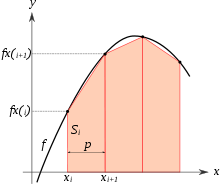

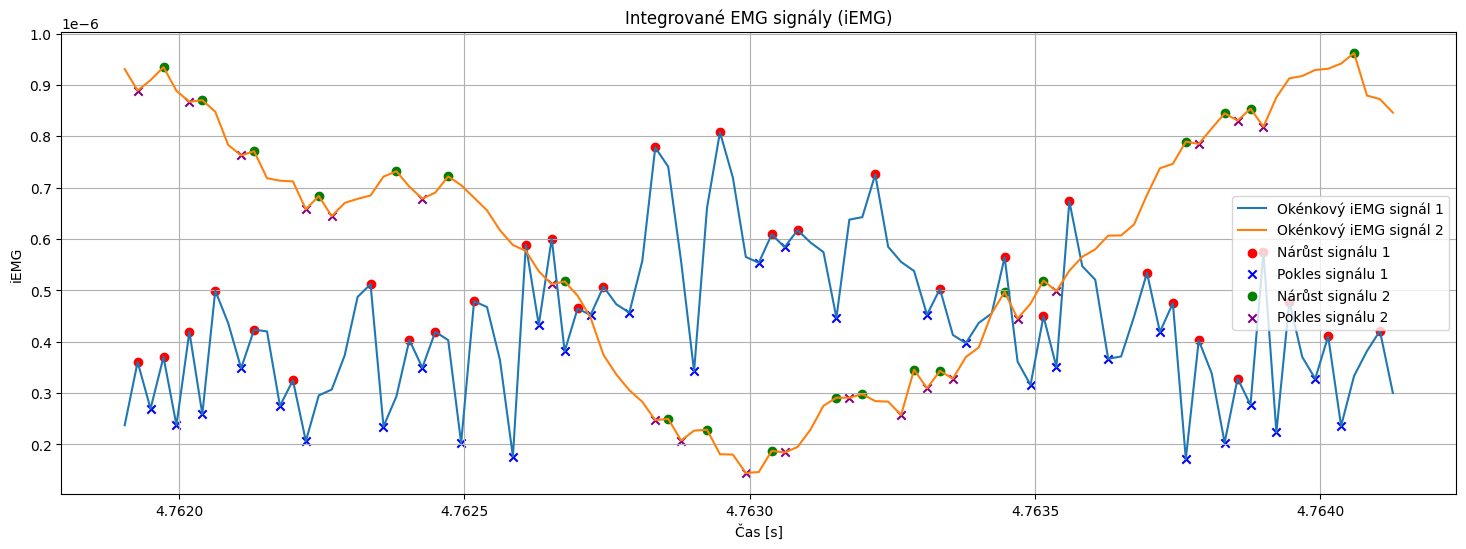

In [11]:
# Výpočet integrovaného EMG (iEMG) pomocí Lichoběžníkové metody
# Použijeme funkci np.trapz pro numerický výpočet integrálu
# To nám spočítá plochu pod křivkou absolutního EMG signálu
# a tím získáme hodnotu iEMG
iemg1 = np.trapz(emg1_abs, time)
iemg2 = np.trapz(emg2_abs, time)

# Funkce pro výpočet okénkového iEMG
def windowed_iemg(signal, time, window_size):
    """ Tato funkce slouží k výpočtu okénkového integrovaného 
    EMG (iEMG) ze vstupního signálu v zadaných časových oknech pomocí Lichoběžníkové metody.

    Args:
        signal (numpy.ndarray): Pole obsahující hodnoty signálu, pro který se má vypočítat okénkové iEMG.
        time  (numpy.ndarray): Pole obsahující časové hodnoty odpovídající každému vzorku signálu.
        window_size (int): Velikost okénka v počtu vzorků, ve kterém se má vypočítat iEMG.

    Returns:
        numpy.ndarray: Pole obsahující okénkové iEMG hodnoty pro každé definované okénko.
    """
    
    # Vypočet počtu vozrkovacích windows na základě velikosti window_size
    num_windows = len(signal) // window_size
    
    # Inicializace pole pro ukládání vozrkovacích windows iEMG hodnot
    windowed_iemg_values = []
    
    # iterace přes všechny windows
    for i in range(num_windows):
        start = i * window_size # Počáteční index aktuálního window
        end = start + window_size  # Koncový index aktuálního window
        
        # Výpočet iEMG pro aktuální window pomocí Lichoběžníkové metody
        window_iemg = np.trapz(np.abs(signal[start:end]), time[start:end])
        # Přidání vypočtené hodnoty do pole
        windowed_iemg_values.append(window_iemg)
    # Převod pole na numpy array a vrácení
    return np.array(windowed_iemg_values)


# Funkce pro nalezení nárůstů a poklesů
def find_peaks_troughs(signal):
    """ Tato funkce slouží k nalezení nárůstů a poklesů v zadaném signálu.

    Args:
        signal (numpy.ndarray): Pole obsahující hodnoty signálu, ve kterém se mají nárůsty a poklesy hledat.

    Returns:
        tuple: Dvojice obsahující pole s indexy nárůstů a pole s indexy poklesů.
    """
    peaks = [] # Pole pro ukládání indexů nárůstů
    troughs = [] # Pole pro ukládání indexů poklesů
    
    # Iterace přes všechny vzorky signálu
    for i in range(1, len(signal) - 1):
        
        # Podmínka pro nalezení nárůstů
        # Pokud je aktuální vzorek větší než předchozí a větší než následující
        # Tak se jedná o nárůst a přidáme index do pole peaks
        # Jinak pokud je aktuální vzorek menší než předchozí a menší než následující
        # Tak se jedná o pokles a přidáme index do pole troughs
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1]:
            peaks.append(i)
        elif signal[i] < signal[i - 1] and signal[i] < signal[i + 1]:
            troughs.append(i)
    return peaks, troughs


# Definujeme velikost okénka
window_size = 10


# Výpočet windows iEMG pro oba signály
windowed_iemg1 = windowed_iemg(emg1, time, window_size)
windowed_iemg2 = windowed_iemg(emg2, time, window_size)


# Nalezení nárůstů a poklesů v okénkových iEMG signálech
peaks1, troughs1 = find_peaks_troughs(windowed_iemg1)
peaks2, troughs2 = find_peaks_troughs(windowed_iemg2)


# Vykreslení iEMG signálů
plt.figure(figsize=(18, 6))
plt.plot(time[:len(windowed_iemg1)], windowed_iemg1, label='Okénkový iEMG signál 1')
plt.plot(time[:len(windowed_iemg2)], windowed_iemg2, label='Okénkový iEMG signál 2')


# Označení nárůstů a poklesů pro signál 1
plt.scatter(time[peaks1], windowed_iemg1[peaks1], color='red', marker='o', label='Nárůst signálu 1')
plt.scatter(time[troughs1], windowed_iemg1[troughs1], color='blue', marker='x', label='Pokles signálu 1')

# Označení nárůstů a poklesů pro signál 2
plt.scatter(time[peaks2], windowed_iemg2[peaks2], color='green', marker='o', label='Nárůst signálu 2')
plt.scatter(time[troughs2], windowed_iemg2[troughs2], color='purple', marker='x', label='Pokles signálu 2')

plt.title('Integrované EMG signály (iEMG)')
plt.xlabel('Čas [s]')
plt.ylabel('iEMG')
plt.legend()
plt.grid(True)
plt.show()

## Slovní ohodnocení

Postupně jsem se věnoval zpracování dat. Začal jsem načtením informací ze souboru a jejich následným zobrazením. 

Při rozhodování, jak postupovat dál, jsem se zaměřil na požadovanou úpravu na **absolutní hodnoty**. Tento krok mi pomohl eliminovat záporné hodnoty, což je běžná praxe při zpracování EMG signálů. 
    
Poté, co jsem zvažoval různé možnosti, jako například **derivaci**, která se ale ukázala jako neúčinná pak jsem pokračoval ve hledání vhodné metody. Po průzkumu jsem objevil **lichoběžníkovou metodu**, která je dostupná v knihovně NumPy. Její implementace mi umožnila získat užitečné grafické výstupy, na kterých jsem následně označil významné body jako jsou nárůsty a poklesy. 

Celkově jsem díky tomuto zpracování signálů získal užitečné poznatky o lichoběžníkové metodě a jejím využití při analýze EMG dat.

#### Literatura (zdroje)
1. Lichoběžníková metoda. Online. Dostupné z: https://cs.wikipedia.org/wiki/Lichob%C4%9B%C5%BEn%C3%ADkov%C3%A1_metoda. [cit. 2024-06-20].
2. Numpy trapz. Online. Dostupné z: https://www.programiz.com/python-programming/numpy/methods/trapz. [cit. 2024-06-20].
3. Lichoběžníková metoda. Online. Dostupné z: https://www.itnetwork.cz/algoritmy/matematicke/algoritmus-numericke-integrovani-lichobeznikova-metoda. [cit. 2024-06-20].

